In [1]:
import pandas as pd
import nolds
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, filtfilt, find_peaks, welch
from scipy.interpolate import interp1d
from scipy.fftpack import fft



# Pan-Tompkins Algorithm

In [2]:

def bandpass_filter(data, lowcut=5, highcut=15, signal_freq=256, filter_order=5):
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype="band")
    y = filtfilt(b, a, data)
    return y
def differentiate(ecg_filtered):
    # Central difference: derivative approximation
    differentiated_ecg = np.ediff1d(ecg_filtered)
    return differentiated_ecg

def square(differentiated_ecg):
    squared_ecg = differentiated_ecg ** 2
    return squared_ecg

def moving_window_integration(squared_ecg, window_size=10):
    integrator = np.convolve(squared_ecg, np.ones(window_size)/window_size, mode='same')
    return integrator
def detect_peaks(integrated_ecg, threshold=0.5):
    peaks, _ = find_peaks(integrated_ecg, height=threshold)
    return peaks

In [3]:
# ECG data loading here (ecg_data)
ecg_data= pd.read_csv('ecg2.csv')

# Convert the specific column to a numpy array
ecg_signal = ecg_data['Trial 1:0back'].values 

# Now you can pass this 1D array to the filter function
ecg_filtered = bandpass_filter(ecg_signal)

# Step 2: Differentiate the ECG signal
ecg_differentiated = differentiate(ecg_filtered)

# Step 3: Square the differentiated ECG signal
ecg_squared = square(ecg_differentiated)

# Step 4: Integrate the squared ECG signal
ecg_integrated = moving_window_integration(ecg_squared)

#Normalization
Normalized=(ecg_integrated -np.min(ecg_integrated))/(np.max(ecg_integrated)-np.min(ecg_integrated))*2-1
# Step 5: Detect peaks
threshold=0.009
peaks = detect_peaks(ecg_integrated, threshold=threshold)

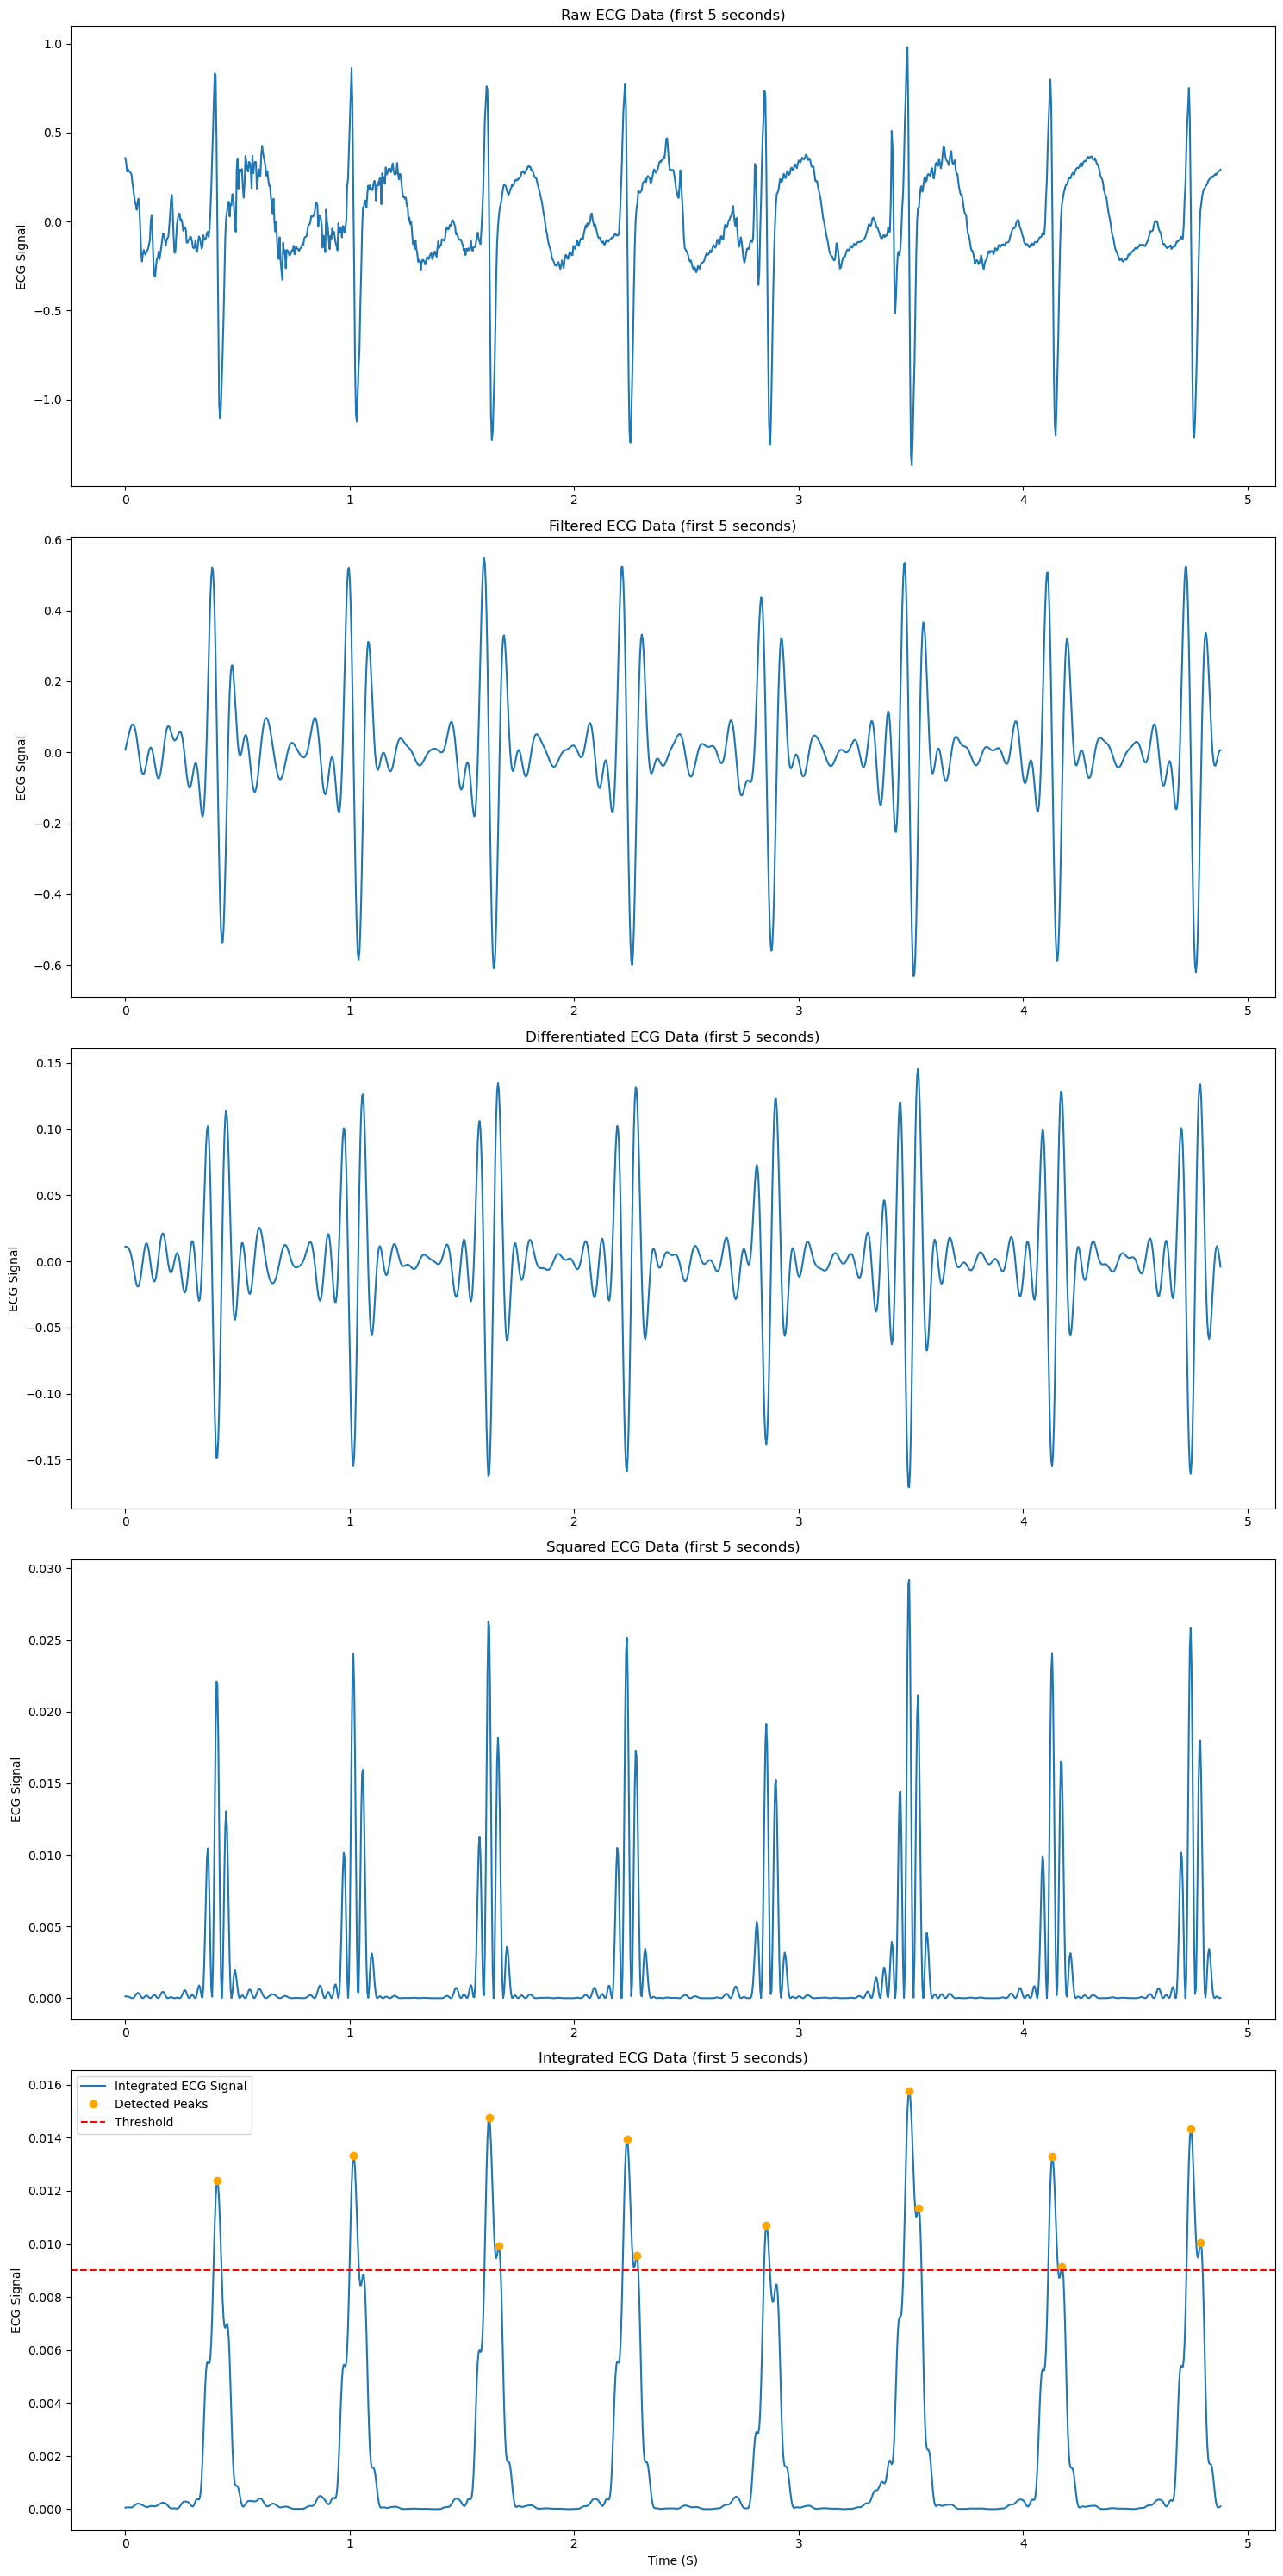

In [4]:

# Plot the original, filtered, and processed ECG signal to inspect
plt.figure(figsize=(15, 30))

plt.subplot(5, 1, 1)
plt.plot(ecg_signal[:1250])
plt.title('Raw ECG Data (first 5 seconds)')
plt.ylabel('ECG Signal')
second_ticks = [i * 256 for i in range(6)]  
plt.xticks(second_ticks, labels=[str(i) for i in range(6)])

plt.subplot(5, 1, 2)
plt.plot(ecg_filtered[:1250])
plt.title('Filtered ECG Data (first 5 seconds)')
plt.ylabel('ECG Signal')
second_ticks = [i * 256 for i in range(6)]  
plt.xticks(second_ticks, labels=[str(i) for i in range(6)])

plt.subplot(5, 1, 3)
plt.plot(ecg_differentiated[:1250])
plt.title('Differentiated ECG Data (first 5 seconds)')
plt.ylabel('ECG Signal')
second_ticks = [i * 256 for i in range(6)]  
plt.xticks(second_ticks, labels=[str(i) for i in range(6)])

plt.subplot(5, 1, 4)
plt.plot(ecg_squared[:1250])
plt.title('Squared ECG Data (first 5 seconds)')
plt.ylabel('ECG Signal')
second_ticks = [i * 256 for i in range(6)]  
plt.xticks(second_ticks, labels=[str(i) for i in range(6)])



plt.subplot(5, 1, 5)
plt.plot(ecg_integrated[:1250], label='Integrated ECG Signal')
plt.title('Integrated ECG Data (first 5 seconds)')
plt.ylabel('ECG Signal')
second_ticks = [i * 256 for i in range(6)]  
plt.xticks(second_ticks, labels=[str(i) for i in range(6)])
peaks_within_range = peaks[peaks < 1250]
# Plot the peaks within this range
plt.plot(peaks_within_range, ecg_integrated[peaks_within_range], 'o', color='orange', label='Detected Peaks')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
second_ticks = [i * 256 for i in range(6)]  
plt.xticks(second_ticks, labels=[str(i) for i in range(6)])
plt.xlabel('Time (S)')




plt.tight_layout()
plt.show()

## Compute RR Intervals

In [5]:
sampling_rate = 256  

# Calculate differences between successive peaks to get RR intervals in samples
rr_intervals_samples = np.diff(peaks)


In [6]:
filtered_peaks = [peaks[0]]  # Always keep the first peak

# Iterate through RR intervals and keep peaks leading to valid intervals
for i, interval in enumerate(rr_intervals_samples):
    if interval > 100:
        # The interval is valid, so keep the next peak (i+1, because rr_intervals_samples is diff of peaks)
        filtered_peaks.append(peaks[i + 1])

# Convert filtered_peaks list to a numpy array if necessary
filtered_peaks = np.array(filtered_peaks)
rr_intervals_samples=rr_intervals_samples[rr_intervals_samples>100]

# Convert RR intervals from samples to milliseconds (1000 ms in 1 second)
rr_intervals_ms = (rr_intervals_samples / sampling_rate) * 1000
rr_intervals_s = rr_intervals_ms / 1000.0
# Shift the RR intervals by one to compare each interval with the next
rr_intervals_shifted = np.roll(rr_intervals_ms, -1)
# Remove the last element since it's shifted and doesn't have a next interval to compare with
rr_intervals_ms = rr_intervals_ms[:-1]
rr_intervals_shifted = rr_intervals_shifted[:-1]
meanrr= np.mean(rr_intervals_ms)

### Peak detection after removing peaks with interval less than 100 seconds

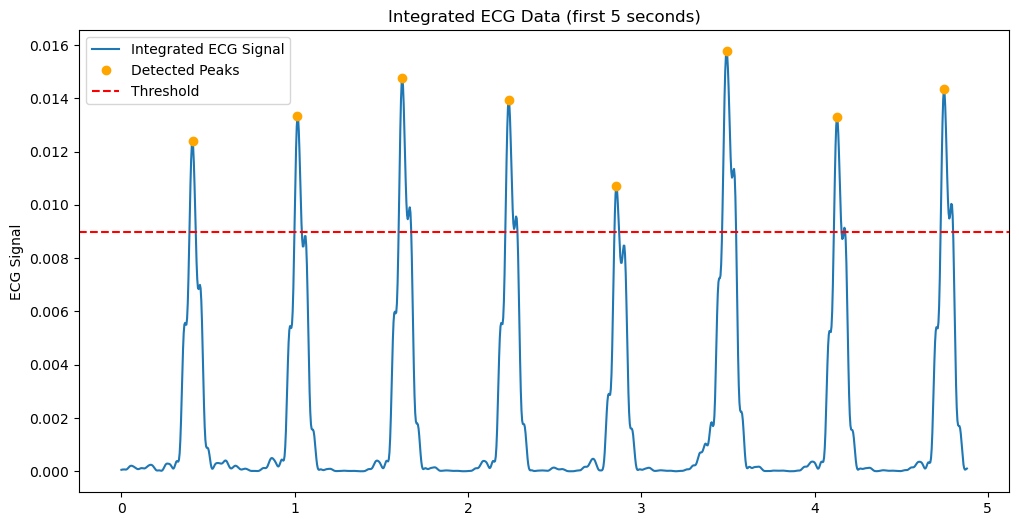

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(ecg_integrated[:1250], label='Integrated ECG Signal')
plt.title('Integrated ECG Data (first 5 seconds)')
plt.ylabel('ECG Signal')
second_ticks = [i * 256 for i in range(6)]  
plt.xticks(second_ticks, labels=[str(i) for i in range(6)])
peaks_within_range = filtered_peaks[filtered_peaks < 1250]
# Plot the peaks within this range
plt.plot(peaks_within_range, ecg_integrated[peaks_within_range], 'o', color='orange', label='Detected Peaks')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.legend()

## Poincaré plot

## Compute HR (bpm)

In [8]:
# HR
rr_intervals_s = rr_intervals_ms / 1000.0
HR= 60/rr_intervals_s
MeanHR= np.mean(HR)
MeanHR

70.54011402209089

### HRV fluctuation plot

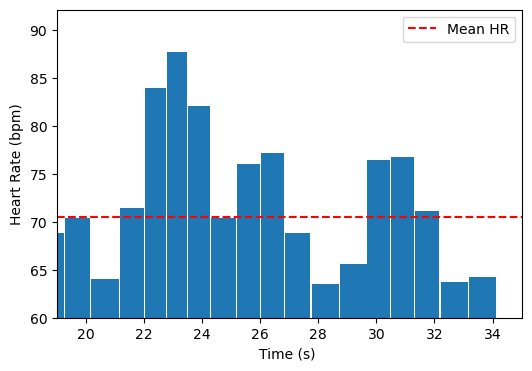

In [9]:
rr_times = ((filtered_peaks[:-1] + rr_intervals_samples / 2) / sampling_rate)
rr_times= rr_times[:-1]

# Create bar plot
plt.figure(figsize=(6,4))
plt.bar(rr_times[25:45], HR[25:45], width = rr_intervals_s[25:45])  # Add edgecolor and linewidth here
# Labeling axes
plt.xlabel('Time (s) ')
plt.ylabel('Heart Rate (bpm)')
plt.title('')
plt.ylim(bottom=60) 
plt.xlim(left=19)
plt.axhline(y=MeanHR, color='red', linestyle='--', label='Mean HR')
plt.legend()
plt.savefig('HRoT0_back.png', dpi=300, bbox_inches='tight')
plt.show()


# Analyzing HRV

## 1-Time-domain Methods

In [10]:
# SDNN Calculation
sdnn = np.std(rr_intervals_ms, ddof=1)  
# RMSSD Calculation
differences = np.diff(rr_intervals_ms)
squared_differences = differences ** 2
mean_squared_differences = np.mean(squared_differences)
rmssd = np.sqrt(mean_squared_differences)
print(sdnn)

110.32730860437164


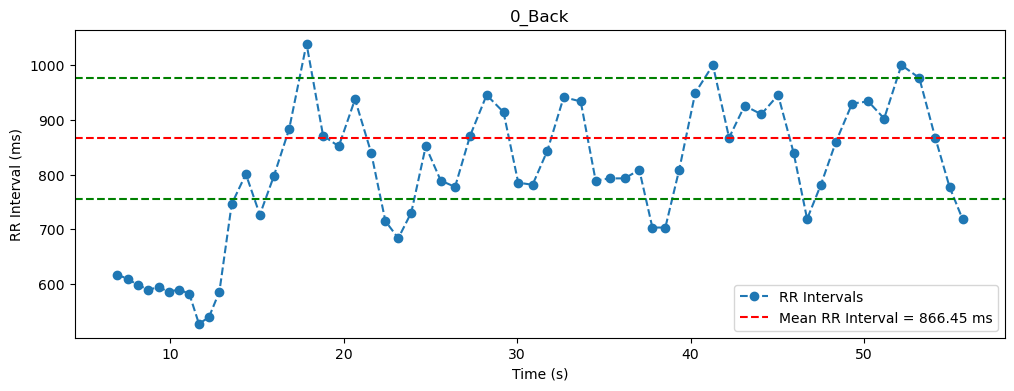

In [11]:
# Time of each RR interval measurement (in seconds), using the midpoint between peaks for plotting
rr_times = (filtered_peaks[:-1] + rr_intervals_samples / 2) / sampling_rate

# Plotting the RR intervals
plt.figure(figsize=(12,4))
plt.plot(rr_times [10:70], rr_intervals_ms[10:70], label='RR Intervals', marker='o', linestyle='--')
plt.axhline(y=meanrr, color='red', linestyle='--', label=f'Mean RR Interval = {meanrr:.2f} ms')
plt.axhline(y=meanrr+sdnn, color='green', linestyle='--')
plt.axhline(y=meanrr- sdnn, color='green', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('RR Interval (ms)')
plt.legend()
plt.title('0_Back')
plt.savefig('RR0_.png', dpi=300, bbox_inches='tight')
plt.show()

## 2-Frequency Domain Methods

In [12]:
# Convert RR intervals to seconds
rr_intervals_s = rr_intervals_ms / 1000.0

# Create a time array for the RR intervals, the first interval starts at t=0
time_array = np.cumsum(rr_intervals_s)  # Cumulative sum to get the timestamps of each RR interval
time_array = np.insert(time_array, 0, 0)  # Insert 0 at the start since the first RR interval starts at t=0

# Interpolate to get an evenly spaced signal
# Define the new time array for the interpolated signal, e.g., 4 Hz sampling rate
new_sampling_rate = 4  # 4 samples per second (4 Hz)
new_time_array = np.arange(0, time_array[-1], 1/new_sampling_rate)

# Interpolate the RR intervals to this new time array
interpolated_func = interp1d(time_array, np.insert(rr_intervals_s, 0, rr_intervals_s[0]))  # Repeat the first value for 0
interpolated_rr = interpolated_func(new_time_array)

In [13]:
# Compute the power spectral density using Welch's method
frequencies, powers = welch(interpolated_rr, fs=new_sampling_rate, nperseg=len(interpolated_rr)/2)
# Mask for extracting LF and HF components
lf_mask = (frequencies >= 0.04) & (frequencies <= 0.15)
hf_mask = (frequencies >= 0.15) & (frequencies <= 0.4)
vlf=(frequencies >= 0.003) & (frequencies <= 0.04)
# Calculate LF and HF by integrating the PSD over the respective frequency bands
lf_power = np.trapz(powers[lf_mask], frequencies[lf_mask])
hf_power = np.trapz(powers[hf_mask], frequencies[hf_mask])
vlf_power=np.trapz(powers[vlf], frequencies[vlf])
# Calculate LF/HF Ratio
lf_hf_ratio = lf_power / hf_power



### Power spectrum plot

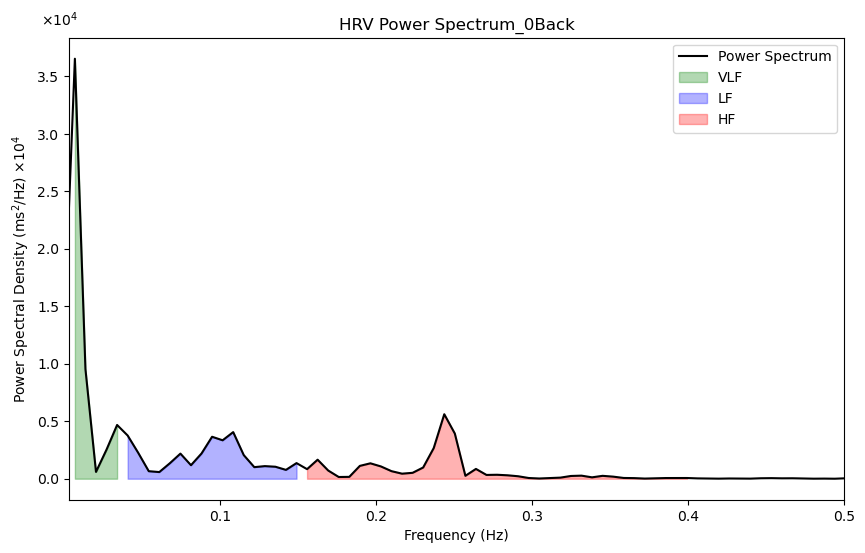

In [14]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

plt.figure(figsize=(10, 6))
plt.plot(frequencies , powers*10, label='Power Spectrum', color='black')  # Plot the power spectrum
plt.xlim([0.003, 0.5])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (ms$^2$/Hz) $\\times 10^4$')

# Define masks for frequency bands
lf_mask = (frequencies >= 0.04) & (frequencies <= 0.15)
hf_mask = (frequencies >= 0.15) & (frequencies <= 0.4)
vlf_mask = (frequencies >= 0.003) & (frequencies <= 0.04)

# Fill the areas under the curve for each frequency band
plt.fill_between(frequencies, powers*10, where=vlf_mask, color='green', alpha=0.3, label='VLF')
plt.fill_between(frequencies, powers*10, where=lf_mask, color='blue', alpha=0.3, label='LF')
plt.fill_between(frequencies, powers*10, where=hf_mask, color='red', alpha=0.3, label='HF')

# Add scale notation to the top left corner
plt.annotate(r'$\times 10^4$', xy=(0, 1), xycoords='axes fraction', xytext=(-20, 20), 
             textcoords='offset points', ha='left', va='top', fontsize=10)

plt.title('HRV Power Spectrum_0Back')
plt.legend()
plt.savefig('freqdomain0.png', dpi=300, bbox_inches='tight')
plt.show()



## Non-linear Methods

In [15]:
sampen = nolds.sampen(rr_intervals_s)


### Poincaré plot

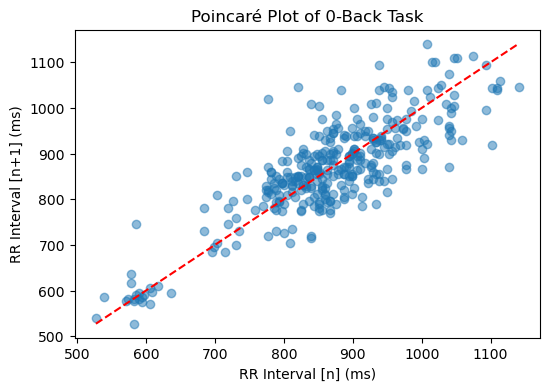

In [16]:
# Plotting the Poincaré plot
plt.figure(figsize=(6, 4))
plt.scatter(rr_intervals_ms, rr_intervals_shifted, alpha=0.5)
plt.title('Poincaré Plot of 0-Back Task')
plt.xlabel('RR Interval [n] (ms)')
plt.ylabel('RR Interval [n+1] (ms)')
plt.plot([min(rr_intervals_ms), max(rr_intervals_ms)], [min(rr_intervals_ms), max(rr_intervals_ms)], 'r--') # Identity line
plt.savefig('Poincar_0back.png', dpi=300, bbox_inches='tight')
plt.show()

## Print the features

In [17]:
print(f"MeanRR:{meanrr:.3f}")
print(f"MeanHR:{MeanHR:.3f}")
print(f"SDNN: {sdnn:.3f}, RMSSD: {rmssd:.3f}")
print(f"LF Power: {lf_power:.4f}, HF Power: {hf_power:.4f}, LF/HF Ratio: {lf_hf_ratio:.3f}")
print(f"VLF Power: {vlf_power:.3f}")
print(f"Sample Entropy: {sampen:.3f}")

MeanRR:866.454
MeanHR:70.540
SDNN: 110.327, RMSSD: 63.205
LF Power: 0.0020, HF Power: 0.0017, LF/HF Ratio: 1.184
VLF Power: 0.002
Sample Entropy: 1.328


## Read features in Excel file

In [18]:
from openpyxl import Workbook, load_workbook
from openpyxl.utils import get_column_letter

#  results
results = [meanrr, sdnn, rmssd, lf_power, hf_power, lf_hf_ratio, sampen]

# Column and row settings
column = 2  # Column B
start_row = 1  # Start at the first row

# Excel file path
file_path = 'result.xlsx'

try:
    # Try to load the workbook if it exists
    wb = load_workbook(file_path)
except FileNotFoundError:
    # If the workbook does not exist, create it
    wb = Workbook()

# Ensure the second sheet exists
if len(wb.sheetnames) < 6:
    wb.create_sheet("Trial1", 0)  # Create a new sheet as the second sheet

sheet = wb.worksheets[0]  # Select the second sheet

# Set the header for column "P1"
sheet[f'{get_column_letter(column)}{start_row}'] = "P1"
start_row += 1  # Move to the next row after header

# Define the metrics names to use as headers in column 1
metrics_names = [
    "MeanHR",
    "MeanRR",
    "SDNN",
    "RMSSD",
    "LF Power",
    "HF Power",
    "LF/HF Ratio",
    "vlf_power",
    "Sample Entropy"
    
]

# Write the results to column "B", starting from row 2 (after the header)
for row, (metric_name, result) in enumerate(zip(metrics_names, results), start=start_row):
    # Write metric name in column 1 (A)
    sheet[f'{get_column_letter(column-1)}{row}'] = metric_name
    # Write metric value in column 2 (B)
    sheet[f'{get_column_letter(column)}{row}'] = result

# Save the workbook
wb.save(file_path)
